# Generate synthetic data with pattern

In [1]:
import numpy as np

sample_size = 2518

with open('data.csv', 'w') as f:
    f.write('time,data\n')
    for i in range(sample_size):
        i -= sample_size / 2
        rad = np.deg2rad(2*i)
        y = np.sin(rad) + 100 * (i * i * i/ sample_size / sample_size / sample_size)
        f.write(f'{i},{y}\n')

# Prepare the model

In [11]:
import pandas as pd
import torch
print(torch.cuda.is_available())
from chronos import ChronosBoltPipeline
from chronos import ChronosModel

prediction_len = 192

pipeline = ChronosBoltPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv('data.csv')

True


D:\Documents\Programming\Python\Chronos\.venv\Lib\site-packages\chronos\chronos_bolt.py:527: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


# Prediction using either the pipeline or by directly calling the model

In [13]:
# Prediction by using the pipeline:

# forecast = pipeline.predict(
#     context=torch.tensor(df["data"]), prediction_length=prediction_len
# )
# m = torch.stack([
#     torch.tensor([x + sample_size for x in range(prediction_len)]).float(),
#     forecast.mean(dim=1).squeeze()
# ])

# Prediction by calling the model:

pipeline.model.to("cuda")
context_tensor = torch.tensor([df["data"]]).to("cuda")
forecast = torch.tensor([]).to('cpu')
for i in range(3):
    with torch.no_grad():
        pred = pipeline.model(context=context_tensor).quantile_preds
        avg = pred.mean(dim=1)
        forecast = torch.cat((forecast, avg[0].to('cpu')), dim=0)
        context_tensor = torch.cat((context_tensor, avg), dim=1)
m = torch.stack([
    torch.tensor([x + sample_size for x in range(prediction_len)]).float(),
    forecast
])

# Visualization

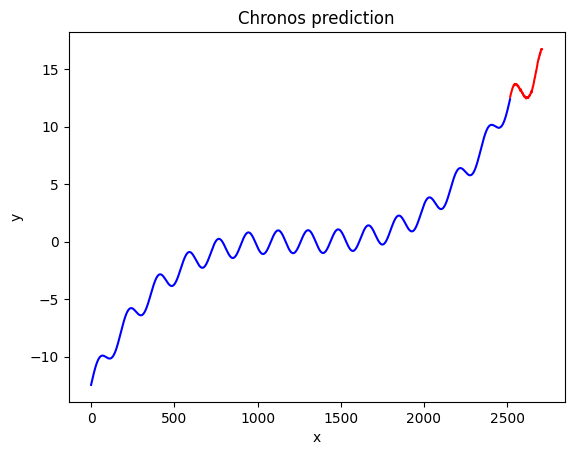

In [14]:
import matplotlib.pyplot as plt

plt.plot(df['data'], color='blue')
plt.plot(m[0], m[1], color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Chronos prediction')
plt.show()

In [15]:
# model architecture
print(pipeline.model)

ChronosBoltModelForForecasting(
  (shared): Embedding(2, 768)
  (input_patch_embedding): ResidualBlock(
    (dropout): Dropout(p=0.1, inplace=False)
    (hidden_layer): Linear(in_features=32, out_features=3072, bias=True)
    (act): ReLU()
    (output_layer): Linear(in_features=3072, out_features=768, bias=True)
    (residual_layer): Linear(in_features=32, out_features=768, bias=True)
  )
  (patch): Patch()
  (instance_norm): InstanceNorm()
  (encoder): T5Stack(
    (embed_tokens): Embedding(2, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding